# Ejercicio 2

In [1]:
# Importacion de librerias #
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats

Importamos la data y hacemos una primer graficación de la red. 

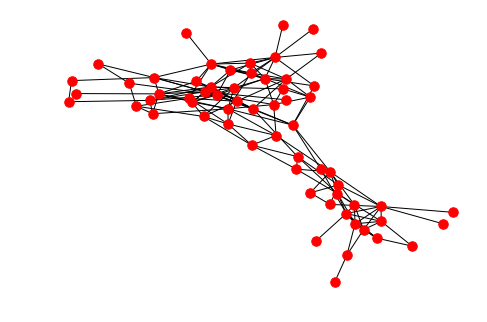

In [44]:
G=nx.read_gml('dolphins.gml')
nx.draw(G, with_labels=False, font_weight='bold',node_size=90)
plt.show()

Incorporamos el género correspondiente a cada delfín. Además incluimos una clave de colores: rojo = hembra, azul = macho y gris =  NA 

In [45]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

data_gender=ldata('dolphinsGender.txt')
data_gender
colores=[]

# Le agregamos el atributo "genero" al grafo G
for elemento in data_gender:
    G.node[elemento[0]]['genero']=elemento[1]
    
# Creamos un vector de colores que vincula los generos (mismo orden)     
for node in G.node:
    gen = G.node[node]['genero']
    #print(node,gen)
    if gen=='f':
        colores.append('red')
    elif gen=='m':
        colores.append('blue')
    else:
        colores.append('grey')
        


### Representación gráfica con género incluído 

Este primer gráfico muestra que la red está compuesta por dos "comunas", a primera vista no se puede distinguir si es una red homofílica. 

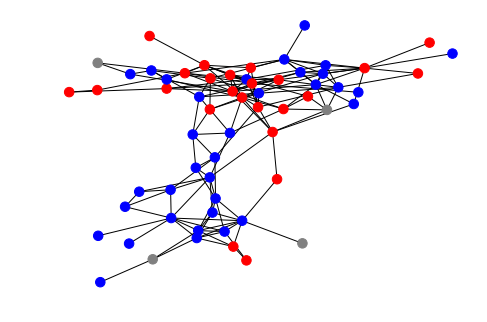

In [46]:
nx.draw(G, with_labels=False,node_color=colores, font_weight='bold',node_grouping='genero',node_size=90)
plt.show()

Utilizamos otros layouts para representar la red. 

Le asignamos colores distintos segun el tipo de enlaces. Los enlaces homofilicos (macho-macho o hembra-hembra) tendrán color púrpura. Los enlaces heterofilicos (hembra-macho) tendran color verde. Esto nos permite tener una primera idea "visual" de la cantidad de enlaces de cada tipo. 

Los enlaces que involucran delfines con género indeterminado serán excluidos.

In [47]:
# Creamos una lista de enlaces homofilicos y otra lista de enlaces heterofilicos
lista_hetero =[]
lista_homo = []
for i in range(0,len(list(G.edges))):
    if(G.node[list(G.edges)[i][0]]['genero']!='NA' and G.node[list(G.edges)[i][1]]['genero']!='NA'):     
        if G.node[list(G.edges)[i][0]]['genero']==G.node[list(G.edges)[i][1]]['genero']:
            lista_homo +=[(list(G.edges)[i][0],list(G.edges)[i][1])] 
        else:
            lista_hetero+=[(list(G.edges)[i][0],list(G.edges)[i][1])] 
    else:
        pass

### Gráfico con layout random

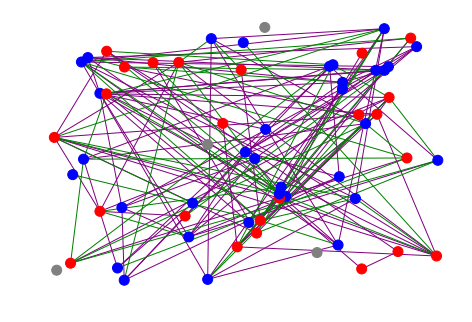

In [48]:
pos=nx.random_layout(G)
nx.draw(G, with_labels=False,node_color=colores, font_weight='bold',node_size=100,pos=pos,edge_width=0.1,edge_color='w')
nx.draw_networkx_edges(G,pos,edgelist=lista_homo,width=1,alpha=1,edge_color='purple')
nx.draw_networkx_edges(G,pos,edgelist=lista_hetero,width=1,alpha=1,edge_color='green')
plt.show()

### Gráfico con layout circular

Consideramos que este último es el layout más informativo de todos ya que permite distinguir con un menor grado de superposición los enlaces entre delfines. 

A primera impresión parece que prevalecen los enlaces homofilicos por sobre los enlaces heterofílicos.

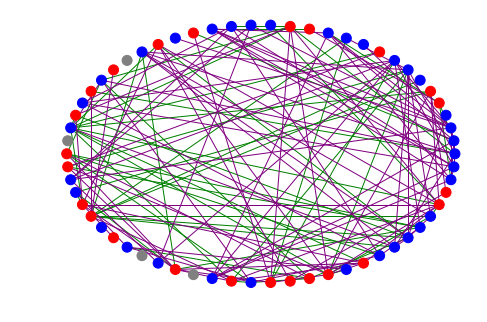

In [49]:
pos=nx.shell_layout(G)
nx.draw(G, with_labels=False,node_color=colores, font_weight='bold',node_size=100,pos=pos,edge_width=0.1,edge_color='w')
nx.draw_networkx_edges(G,pos,edgelist=lista_hetero,width=1,alpha=1,edge_color='green')
nx.draw_networkx_edges(G,pos,edgelist=lista_homo,width=1,alpha=1,edge_color='purple')
plt.show()

## Determinación del grado de homofilia


Si bien la representación gráfica nos da una idea del tipo de red que tenemos. Es necesario caracterizarla en términos cuantitativos. Vamos a determinar si en esta red prevalece la homofilia en la variable género. Para esto calcularemos la fracción de enlaces heterofílicos de la red y luego compararemos este valor con la distribución nula (haciendo asignaciones de género al azar). 

Esta función calcula la fracción de enlaces heterofílicos (enlaces hembra-macho) de una red dada. 

In [55]:
## Calcula la fraccion de enlaces entre nodos de distinto genero ##
def fraccion_mh(G): 
    A = nx.adjacency_matrix(G)  # Matriz de adycencia
    v=0
    enlaces = 0.0  # cantidad de enlaces (excluyendo los NA)
    union_mh = 0.0 # cantidad de enlaces macho-hembra
    for node_v in G:      # Loop de nodo v
        genero_v = nx.get_node_attributes(G, "genero").values()[v]
        w=0
        for node_w in G:  # Loop de nodo w
            genero_w = nx.get_node_attributes(G, "genero").values()[w]
            if (A[v,w]==1):
                if( genero_v!='NA' and  genero_w!='NA'):
                    enlaces += 1.0
                    if(not (genero_v==genero_w)):
                        union_mh+=1.0
            w+=1
        v+=1
    Q = union_mh/enlaces
    return Q


Esta es la función principal del código. Calcula la fracción de enlaces heterofilicos de la red y también calcula la fracción de enlaces heterofilicos de 1500 asignaciones al azar de género. Es importante destacar que la topología de la red original se mantiene inalterada (la matriz de adyacencia es la misma a pesar de las asignaciones de genero al azar). 

El objetivo de esta parte será descartar o conservar la siguiente hipótesis nula: La fracción de enlaces heterofílicos de la red original es estadísticamente compatible con la fracción de enlaces heterofílicos de una red cuyos géneros estén asignados al azar (conservando la topología). 

In [57]:
%%time
####### MAIN ####### 
fraccion_mh_data = fraccion_mh(G)
nodes = nx.get_node_attributes(G, "genero").values()
array_fraccion = []
iter_max = 1500
iteracion=0
G_copy = G.copy()
while iteracion<iter_max:
    random.shuffle(nodes)
    i=0
    for n in G_copy: # cambia el genero de los delfines
        G_copy.node[n]['genero']= nodes[i]
        i+=1
    array_fraccion +=[fraccion_mh(G_copy)] # Array que almacena la fraccion de enlaces hetero para asignaciones random
    iteracion+=1


CPU times: user 6min 2s, sys: 48 ms, total: 6min 2s
Wall time: 6min 2s


Informamos la fracción de enlaces heterofílicos para la red original, el promedio de las 1500 asignaciones al azar y su respectivo desvío estandar. Si bien el valor de la red original parece ser significativamente menor que el obtenido por azar, haremos un análisis estadístico para decidir si rechazar la hipótesis nula.  

In [142]:
print("Fraccion enlaces heterofilicos:")
print "Mean red random =",round(np.mean(array_fraccion),3)
print "Desvio estandar red random=",round(np.std(array_fraccion),3)
print "Red original=",round(fraccion_mh_data,3)

Fraccion enlaces heterofilicos:
Mean red random = 0.494
Desvio estandar red random= 0.042
Red original= 0.454


### Histograma de fracción de enlaces heterofílicos

Graficamos un histograma con la distribución nula. La recta roja representa el valor de la red original. Puede verse que el valor de la original se encuentra apartado del valor medio esperado por azar. 

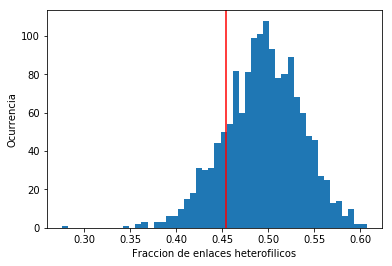

In [128]:
cantidad_bins = 50
plt.axvline(x=fraccion_mh_data,color ='r')
hist, bin_edges = np.histogram(array_fraccion,bins=cantidad_bins)
plt.hist(array_fraccion,bins=cantidad_bins)
plt.xlabel('Fraccion de enlaces heterofilicos')
plt.ylabel('Ocurrencia')
plt.show()

## Análisis de significancia estdística

La función 'find_nearest' será necesaria para cacular el valor p

In [125]:
# Dado un array y un valor, encuentra el indice del valor del array mas cercano al valor pasado (value)
def find_nearest(array, value):
    i=0
    while i<len(array)-1:
        if array[i]<=value and array[i+1]>=value:
            distancia1 = abs(array[i]-value)
            distancia2 = abs(array[i+1]-value)
            if distancia1>=distancia2:
                indice = i+1
            else: 
                indice =i
        i+=1
    return indice

In [127]:
cantidad_bins = 40
bins = np.linspace(min(array_fraccion),max(array_fraccion),cantidad_bins)

def calcula_pvavlue(hist):
    bin_size = bin_edges[1]-bin_edges[0]
    i=0
    suma_parcial=0.0
    while i<=find_nearest(bins,fraccion_mh_data):
        suma_parcial += hist[i]*bin_size
        i+=1
    i=0
    suma_total=0.0
    while i<len(hist):
        suma_total += hist[i]*bin_size
        i+=1  
    valor_p = suma_parcial/suma_total
    return valor_p
valor_p = calcula_pvavlue(hist)
print("Valor p:",valor_p)


('Valor p:', 0.04533333333333336)


El valor p resultó ser menor al valor de significancia 0.05, por lo tanto descartamos la hipótesis nula. 
Es decir, en la red original prevalece la homofilia en la variable género. Ya que es muy improbable que la configuración de la red original ocurra por azar.   

Otra métrica que nos permite cuntificar el grado de homofilia de la red es la modularidad. Encontramos que la red original tiene una modularidad Q = 0.48. Este valor es consistente con el hecho de tener una red homofílica. Ya que la modularidad es positiva cuando el número de enlaces dentro de un mismo grupo excede el numero de enlaces esperados por conexiones al azar [1]. 

In [145]:
def modularity(G):
    m = G.number_of_edges()
    A = nx.adjacency_matrix(G)
    v = 0
    sumando=0.0
    for node_v in G:      # Loop de nodo v
        genero_v = nx.get_node_attributes(G, "genero").values()[v]
        w=0
        for node_w in G:  # Loop de nodo w
            genero_w = nx.get_node_attributes(G, "genero").values()[w]
            if( genero_v!='NA' and  genero_w!='NA'):
                if( genero_v==genero_w):
                    kv = list(G.degree)[v][1]
                    kw = list(G.degree)[w][1]
                    sumando+= A[v,w] - (kv*kw)/(2*m)

            w+=1
        v+=1
    modularity = sumando/(2*m)
    return round(modularity,4)

print "Q =", modularity(G)

Q = 0.4843


## Referencias

[1] Li, Wenye; Schuurmans, Dale (2011). "Modular Community Detection in Networks". IJCAI Proceedings-International Joint Conference on Artificial Intelligence. 22 (1): 2